# Bicicletas públicas en Barcelona

Breve estudio del servicio de alquiler de bicicletas públicas en la ciudad de Barcelona [Bicing](https://www.bicing.barcelona/es).

Juan G. Marinero Tarazona

<img align="center" style="width:400px;padding-right:15px;" src="https://www.bicing.barcelona/sites/default/files/2019-01/est.JPG" caption="aaa">

## Índice
1. [Dataset del ayuntamiento de Barcelona](#Descripción-de-los-campos)
1. [Tamaños de los parkings](#Tamaño-de-cada-estación-de-bicicletas)
1. [Aproximación inicial gráfica](#¿A-qué-responde-la-cuantía-de-bicicletas-alquilables-en-cada-momento?)
1. [Añadir variables](#Añadimos-variables-metereológicas,-festividades-y-días-de-la-semana)
1. [Vectores principales (eigenvectors)](#PCA)
1. [Estudio de un parking concreto](#Un-parking-concreto)

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display_html
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from data.data import get_data
from data.weather import get_weather

from data.add_holidays import add_holidays
from data.dataConstructor import dataConstructor

from ML_fcns.cumuExplVariance import cumuExplVariance
from ML_fcns.PCA_LinearRegression import PCA_LinearRegression
from ML_fcns.PCA_plot import PCA_plot

## Descripción de los campos

De la web [Open Data BCN](http://opendata-ajuntament.barcelona.cat/es/) (Servicio de datos abiertos del Ayuntamiento de Barcelona) descargamos el dataset [Estaciones de Bicing de la ciudad de Barcelona (Mecánicas y electricas)](http://opendata-ajuntament.barcelona.cat/data/es/dataset/bicing) de diciembre de 2018.

In [3]:
data = get_data()
data.head()

,id,type,latitude,longitude,streetName,streetNumber,altitude,slots,bikes,nearbyStations,status
updateTime,,,,,,,,,,,
2018-11-30 23:59:14,1,BIKE,41.397952,2.180042,Gran Via Corts Catalanes,760,21,10,17,"24, 369, 387, 426",OPN
2018-11-30 23:59:14,2,BIKE,41.395530,2.177060,Roger de Flor/ Gran Vía,126,21,4,23,"360, 368, 387, 414",OPN
2018-11-30 23:59:14,3,BIKE,41.394055,2.181299,Nàpols,82,22,9,18,"4, 6, 119, 419",OPN
2018-11-30 23:59:14,4,BIKE,41.393480,2.181555,Ribes,13,21,0,20,"3, 5, 359, 419",OPN
2018-11-30 23:59:14,5,BIKE,41.391075,2.180223,Pg Lluís Companys,11,16,1,38,"6, 7, 359, 418",OPN


Comprobamos que no haya NaN.

In [3]:
print(f"¿Faltan datos?: {data.isnull().values.any()}")

¿Faltan datos?: False


Disponemos de unas 3.8 millones de muestras

In [4]:
print(f'{data.shape[0]:g}')

3.78476e+06


Correspondientes a 463 localizaciones distintas

In [5]:
len(set(data.id))

463

Como el nombre del dataset indicaba, las bicicletas se clasifican como mecánicas (``BIKE``) y eléctricas (``BIKE-ELECTRIC``).

In [6]:
set(data.type)

{'BIKE', 'BIKE-ELECTRIC'}

Cada estación de bicicletas puede estar operativa (``OPN``) ó cerrada (``CLS``).

In [7]:
set(data.status)

{'CLS', 'OPN'}

## Tamaño de cada estación de bicicletas

Tamaño de cada rack de bicis es la suma de bicis aparcadas (columna $bikes$) mas los huecos para bicis (columna $slots$).

In [8]:
df = data.copy()
df["rackSize"] = data["bikes"] + data["slots"]
df = df.loc[data['status']=='OPN']

### Tamaño del parking

Los parkings de bicicletas tienen gran diversidad de tamaños.

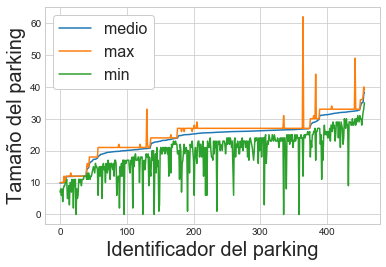

In [9]:
rackSizeMean = df.groupby('id')['rackSize'].mean().sort_values()
plt.plot(rackSizeMean.values, label='medio')
plt.xlabel('Identificador del parking', fontsize=20);
plt.ylabel('Tamaño del parking', fontsize=20);
plt.plot(df.groupby('id')['rackSize'].max()[rackSizeMean.index].values, label='max')
plt.plot(df.groupby('id')['rackSize'].min()[rackSizeMean.index].values, label='min')
plt.legend(framealpha=1, frameon=True, fontsize=16);

Y a su vez en cada parquing fluctúa en gran medida la disponibilidad. En la siguiente gráfica se observa como esta variación está poco correlada al tamaño del parquing, la localización y el momento del día pueden ser mas responsables.

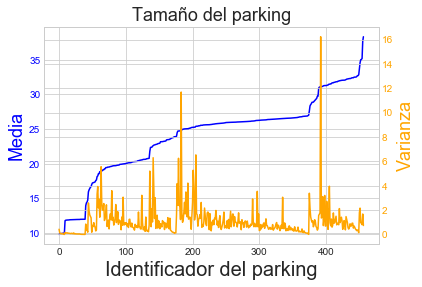

In [10]:
fig, ax1 = plt.subplots()
colors = ["blue", "orange"]

plt.title("Tamaño del parking", fontsize=18)
plt.xlabel('Identificador del parking', fontsize=20);

ax1.plot(rackSizeMean.values, color=colors[0])
ax1.set_ylabel(r"Media", fontsize=18, color=colors[0])
for label in ax1.get_yticklabels():
    label.set_color(colors[0])

aux = df.groupby('id')['rackSize'].var()[rackSizeMean.index]
ax2 = ax1.twinx()
ax2.plot(df.groupby('id')['rackSize'].var()[rackSizeMean.index].values, color=colors[1])
ax2.set_ylabel(r"Varianza", fontsize=18, color=colors[1])
for label in ax2.get_yticklabels():
    label.set_color(colors[1]);

## ¿A qué responde la cuantía de bicicletas alquilables en cada momento?

Gráfica para corroborar sí el día de la semana y su festividad influyen en la cuantía de bicicletas.

In [11]:
# data = get_data()
df_day = pd.DataFrame(data["bikes"][data["status"]=='OPN'].resample('D').sum()[1:-1])

df_day['day_of_week'] = df_day.index.day_name()
df_day = df_day.join(pd.get_dummies(df_day['day_of_week'] ))

df_day = add_holidays(pd.DataFrame(df_day));

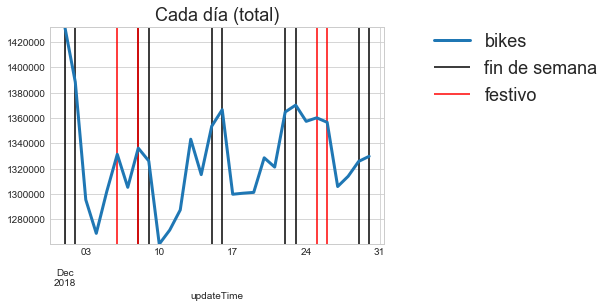

In [12]:
fig, ax = plt.subplots()
maxVal = max(df_day['bikes'])
df_day[['bikes']].plot(ax = ax, linewidth=3)
ax.vlines(x=df_day.index[(df_day['Saturday']==1) | (df_day['Sunday']==1)], ymin=0, ymax=maxVal, label='fin de semana')
ax.vlines(x=df_day.index[df_day['holiday']==1], ymin=0, ymax=maxVal, label='festivo', color='r')

ax.set_ylim(min(df_day['bikes']),maxVal);
ax.set_title('Cada día (total)', fontsize=18);
ax.legend(bbox_to_anchor=(1.1, 1.05), fontsize=18);

La muestra comprende un periodo de tiempo demasiado pequeño, pero dado que la cuantía de localizaciones distintas es considerable (463), no es muy osado presuponer gracias al previo plot que: hay mas bicicletas alquilables los días no laborales, y los días que mas las usan son Lunes y Martes.

También podemos presuponer que mas bicicletas se pueden alquilar (columna $bike$ de $data$) es cuándo la mayoría de la gente ya ha llegado a su destino (trabajo, casa, parque, etc.), es decir, a media mañana, a la hora de comer, a la tarde-noche, etc. 

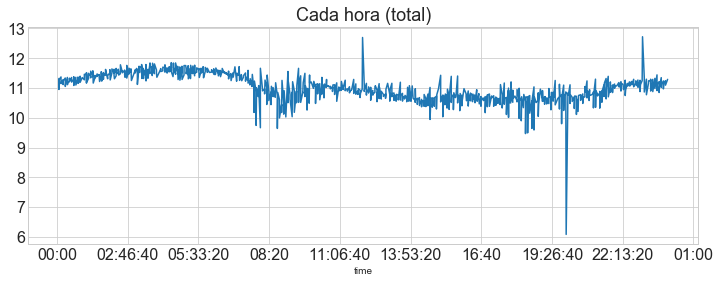

In [13]:
ax = df['bikes'].groupby(df.index.time).mean()[1:-1].plot(fontsize=16, figsize=(12,4));
ax.set_title('Cada hora (total)', fontsize=18);
ax.locator_params(nbins=10, axis='x')

Estudiando los días laborales por separado:

In [14]:
# data = get_data()
df_hour = pd.DataFrame(data["bikes"][data["status"]=='OPN'].resample('H').mean()[1:-1])

df_hour['day_of_week'] = df_hour.index.day_name()
df_hour = df_hour.join(pd.get_dummies(df_hour['day_of_week'] ))

df_hour = add_holidays(pd.DataFrame(df_hour));

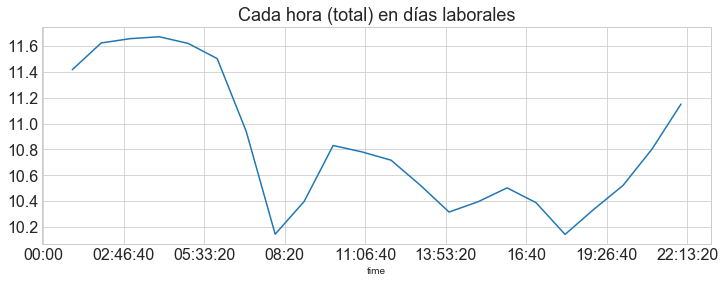

In [15]:
df_hour_workday = df_hour[(df_hour['Saturday']!=1) & (df_hour['Sunday']!=1) & (df_hour['holiday']!=1)]
ax = df_hour_workday['bikes'].groupby(df_hour_workday.index.time).mean()[1:-1].plot(fontsize=16, figsize=(12,4));
ax.set_title('Cada hora (total) en días laborales', fontsize=18);
ax.locator_params(nbins=10, axis='x')

Se observa que aproximadamente:
- de 6 a 8 de la mañana se alquilan muchas bicis (in itinere) 
- de 8 a 10 de la mañana se devuelven muchas de las bicis (in itinere)
- de 18 a 1 de la madrugada progresa pausadamente el estacionar mas que alquilar (ocio y/o in itinere de jornada partida)

## Añadimos variables metereológicas, festividades y días de la semana

La tabla de bicing ($data$) carece de variables metereológicas, las cuales afectan en gran medida en el transporte. En``get_weather()`` hemos seleccionado una serie de variables cuantitativas (como la humedad relativa y la temperatura) y unas variable categórica (LabelEncoders) para determinar la lluvia/niebla ($Light\,drizzle$, $Light\,rain$, $Mist$ y $No\,rain$).

In [2]:
w = get_weather()
w.head()

,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain
Local time in Barcelona (airport),,,,,,,,,
2018-12-31 23:30:00,9,54,7,0,10,0,0,0,1
2018-12-31 23:00:00,10,50,7,0,10,0,0,0,1
2018-12-31 22:30:00,10,50,6,0,10,0,0,0,1
2018-12-31 22:00:00,11,47,5,0,10,0,0,0,1
2018-12-31 21:30:00,11,50,5,0,10,0,0,0,1


Esta dataFrame climatológica, junto con otra de días festivos ($holidais$) y otra de horas de luz diaría (), se mergen con la tabla de bicing inicial $data$.

A su vez a $data$ se filtran las variables de interés y se aplica LabelEncoders de las variables categóricas (como status), así como ``pd.get_dummies()`` al día de la semana.

A este gran dataFrame le quitamos el índice (temporal) y dividimos en las matrices $y$ correspondiente a columna que deseadmos hacer prediciones ($bike$) y el resto a matrix $X$.

In [4]:
#data = get_data();
Xy = dataConstructor(data.copy(),w); # pass copy to NOT modify original

ybar = ["bikes"]

XdC = Xy.drop(columns=ybar)
ydC = Xy[ybar]

Así las variables X son:

In [18]:
XdC.columns.values

array(['id', 'altitude', 'slots', 'holiday', 'daylight_hrs', '°C',
       'Humidity (%)', 'Wind (m/s)', 'Clouds', 'Visibility',
       'Light drizzle', 'Light rain', 'Mist', 'No rain', 'hour', 'status',
       'type', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday'], dtype=object)

Es decir,

In [19]:
rows = 10;
styles = [dict(selector="th", props=[("font-size", "68%"), ("text-align", "center")])]
df1_styler = XdC.iloc[:rows,:].style.set_table_styles(styles).set_properties(**{"font-size": "80%"}).set_table_attributes("style='display:inline'").set_caption('X dataConstructor')\
             .background_gradient(subset=['slots'],cmap='Greens').hide_index()
df2_styler = pd.DataFrame(ydC.iloc[:rows]).style.set_table_styles(styles).set_properties(**{"font-size": "80%"}).set_table_attributes("style='display:inline'").set_caption('y').hide_index()
display_html(df1_styler._repr_html_() + 2*'&nbsp' + df2_styler._repr_html_(), raw=True)

id,altitude,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1,21,10,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
2,21,4,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
3,22,9,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
4,21,0,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
5,16,1,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
6,16,1,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
7,16,0,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
8,11,1,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
9,11,0,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0
11,1,0,0,9.23996,11,67,5,0,10,0,0,0,1,23,1,0,1,0,0,0,0,0,0


# PCA

Para operar necesitamos sólo los valores.

In [20]:
X = XdC.values
y = ydC.values

print(X.shape)
print(y.shape)

(3784760, 24)
(3784760, 1)


Con vectores propio de 1 sola dimensión llegamos a describir el 98% de covarianza, y con 5 ya casi el 100%:

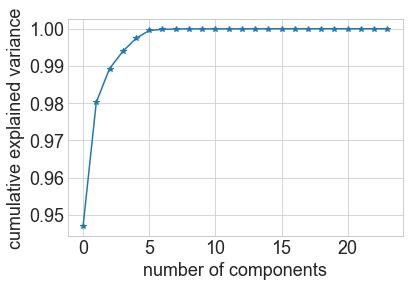

In [21]:
cumuExplVariance(X);

Estimamos a partir de los vectores propios el total de la data (todos los parkings) aplicando una regresión lineal sin regularización:

,id,altitude,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
PC-0,1e+00,3e-02,4e-05,-2e-07,2e-07,4e-06,3e-06,-2e-06,1e-05,-6e-07,1e-08,6e-08,3e-08,-1e-07,-6e-07,-2e-06,1e-03,-2e-07,-8e-08,-2e-08,-1e-08,-2e-07,3e-07,3e-07
PC-1,-3e-02,1e+00,1e-01,-2e-05,8e-06,2e-04,-2e-04,-1e-04,5e-04,-2e-05,5e-07,2e-06,1e-06,-3e-06,3e-04,-2e-04,-1e-03,-4e-06,5e-06,-1e-05,-1e-05,-5e-06,1e-05,1e-05
PC-2,-3e-05,6e-04,-7e-03,7e-03,-5e-04,-5e-02,4e-01,-2e-02,9e-01,-1e-02,3e-04,8e-04,4e-04,-2e-03,-6e-02,6e-06,1e-05,7e-04,-7e-03,-2e-03,-4e-03,3e-03,4e-03,5e-03
PC-3,3e-04,-1e-02,7e-02,6e-04,-7e-04,2e-01,-8e-01,-3e-02,4e-01,1e-02,-4e-04,-9e-04,-4e-04,2e-03,3e-01,-1e-04,-4e-04,-5e-03,5e-03,5e-04,2e-03,-7e-04,-2e-03,-1e-03


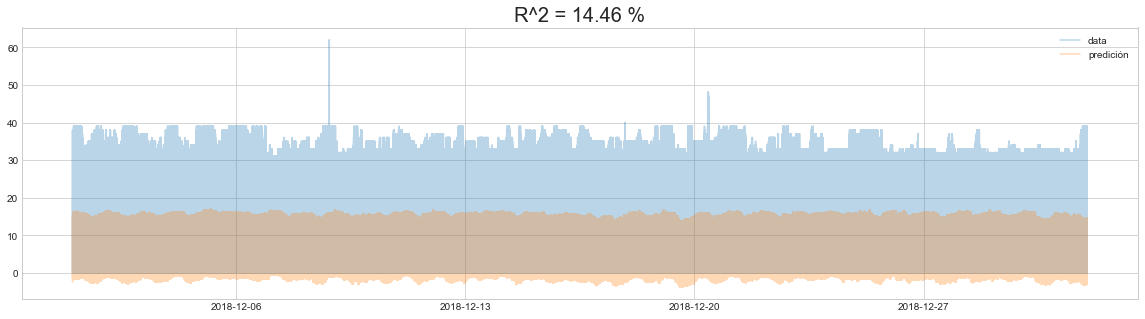

In [22]:
PCA_LinearRegression(XdC, ydC, 4, data.index);

¡Observamos un claro `pitfall`! La variable ``id`` (columna 1) identifica cada parking con un número, y obviamente es una variable categórica que deberíamos haber aplicado ``pd.get_dummies``.

In [23]:
len(list(set(XdC['id'])))

463

463 son muchísmas columnas a añadir, pero aún así dejo indicado los comandos a aplicar:

In [24]:
if False:
    XdC_id_dummies = XdC.copy();
    XdC_id_dummies = XdC_id_dummies.join(pd.get_dummies(XdC['id']))
    XdC_id_dummies.drop(columns=['id'], inplace=True);

    print('Variables: ',XdC_id_dummies.columns)
    print(XdC_id_dummies.head())

    try:
        X = XdC_id_dummies.values
        cumuExplVariance(X);
    except Exception as e: print('Error type: ',e.__class__.__name__)

Sí simplemente eliminamos la columna ``id`` obtenemos:

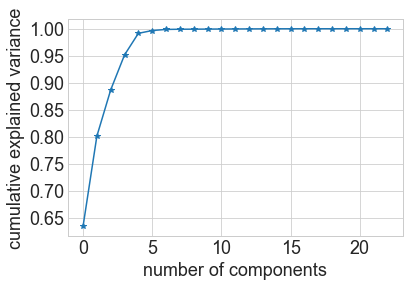

In [5]:
XdC_id_del = XdC.copy();
XdC_id_del.drop(columns=['id'], inplace=True);

X = XdC_id_del.values
cumuExplVariance(X);

,altitude,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
PC-0,1e+00,1e-01,-2e-05,8e-06,2e-04,-2e-04,-1e-04,5e-04,-2e-05,5e-07,2e-06,1e-06,-3e-06,3e-04,-2e-04,2e-05,-4e-06,4e-06,-9e-06,-1e-05,-5e-06,1e-05,1e-05
PC-1,6e-04,-7e-03,7e-03,-5e-04,-5e-02,4e-01,-2e-02,9e-01,-1e-02,3e-04,8e-04,4e-04,-2e-03,-6e-02,6e-06,2e-05,7e-04,-7e-03,-2e-03,-4e-03,3e-03,4e-03,5e-03
PC-2,-1e-02,7e-02,6e-04,-7e-04,2e-01,-8e-01,-3e-02,4e-01,1e-02,-4e-04,-9e-04,-4e-04,2e-03,3e-01,-1e-04,-5e-04,-5e-03,5e-03,5e-04,2e-03,-7e-04,-2e-03,-1e-03
PC-3,-1e-01,1e+00,-6e-04,1e-04,-7e-03,7e-02,-2e-03,-3e-02,-2e-03,3e-05,1e-04,9e-05,-2e-04,7e-03,-2e-03,-9e-03,7e-04,-3e-04,-7e-04,-1e-03,2e-04,6e-04,6e-04


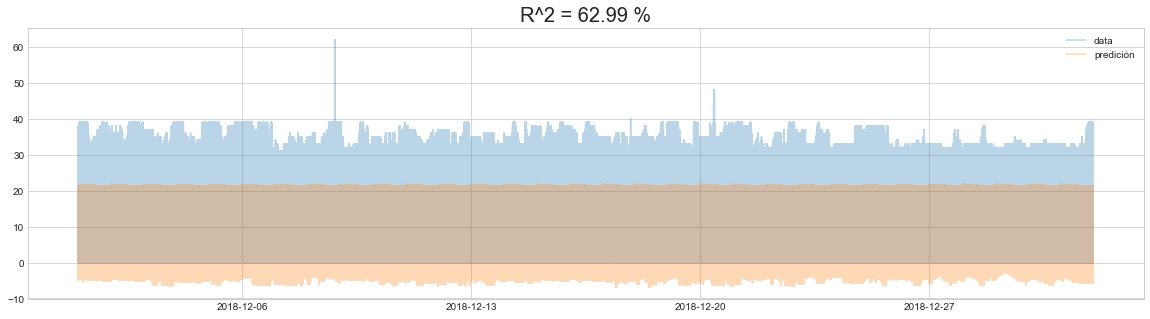

In [26]:
y_predicted = PCA_LinearRegression(XdC_id_del, ydC, 4, data.index);

Recordando el significado de los vectores devueltos por PCA, cito a [behzad.nouri](https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn/22986100#22986100):


Each principal component is a linear combination of the original variables:
$$PC^j \,=\,\beta_1^j\,X_1 \,+\, \beta_2^j\,X_2 \,+\, \cdots \,+\, \beta_n^j\,X_n$$
where $X_i$-s are the original variables, and $\beta_i$-s are the corresponding weights or so called coefficients.

Por tanto, analizando ``pca.components_`` se resalta que:

- ``altitude``: el eigenvector ``PC-0`` está formado por una combinación de las variables originales dónde la variable ``altitude`` es la que mayor peso se la aplica (la variable con mayor varianza).
- ``Clouds``: adquiere gran peso como se observa en ``PC-1`` y ``PC-2``
- resto de variables: como se observa en ``PC-2`` (y en menor medida en ``PC-3`` y ``PC-4``) también tienen una varianza considerable

Sin embargo, hemos obtenido una predición muy errónea (correlación del 63%). Las posibles causas son:
- faltan variables a considerar (como densidad de tráfico y voluntad de hacer ejercicio)
- hay una serie de relaciones NO lineales que no he considerado
- se debe aplicar feature engineering a PCA, por ejemplo customizando el método con filtro de outliers

O simplemente, la data es muy grande e independiente un parking de otro. Si ploteamos solo 1% se observa mejor la poca correlación y la inestabilidad de las curvas.

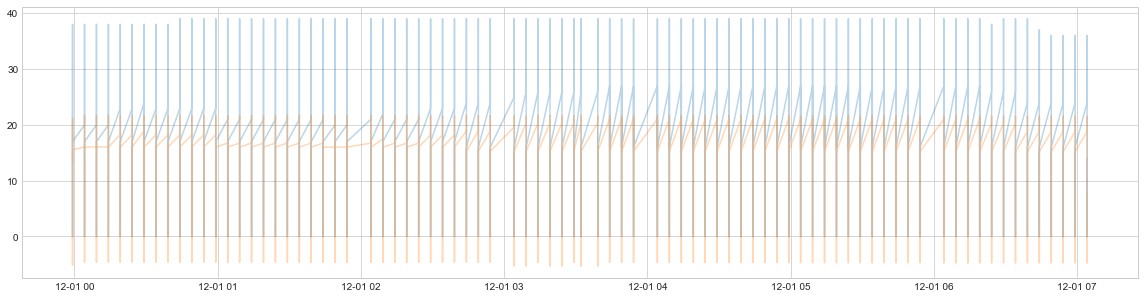

In [27]:
samples = np.int(np.round(data.shape[0] *1/100))
plt.figure(figsize=(20,5))
plt.plot(data.index[:samples], ydC.values[:samples],  alpha =.3, label='data')
plt.plot(data.index[:samples], y_predicted[:samples], alpha =.3, label='predición');

## Un parking concreto

La data es demasiado amplia, vamos a centrarnos en un parking de bicing de Barcelona en concreto.

In [6]:
parking = 13 # por ejemplo

boolArr = XdC['id']==parking
XdC_1pt = XdC[boolArr.values]
ydC_1pt = ydC[boolArr.values]

X = XdC_1pt.values
y = ydC_1pt.values

print(X.shape)
print(y.shape)

(8222, 24)
(8222, 1)


Con vectores propio de 3 dimensiones llegamos a describir el 98% de covarianza:

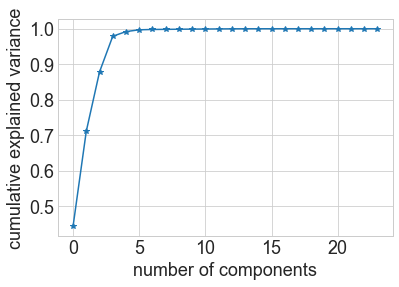

In [29]:
cumuExplVariance(X);

,id,altitude,slots,holiday,daylight_hrs,°C,Humidity (%),Wind (m/s),Clouds,Visibility,Light drizzle,Light rain,Mist,No rain,hour,status,type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
PC-0,7e-18,7e-20,3e-01,7e-03,3e-04,6e-02,5e-01,2e-02,8e-01,1e-02,4e-04,8e-04,5e-04,2e-03,8e-02,0e+00,0e+00,6e-04,8e-03,5e-04,5e-03,3e-03,4e-03,6e-03
PC-1,1e-17,3e-19,7e-01,2e-03,1e-03,1e-01,5e-01,2e-02,5e-01,5e-03,4e-04,3e-04,5e-04,1e-03,2e-01,0e+00,0e+00,1e-03,4e-03,4e-03,3e-03,6e-04,3e-04,1e-03
PC-2,6e-17,6e-18,7e-01,6e-04,4e-04,1e-01,7e-01,3e-02,2e-01,6e-03,8e-05,8e-04,2e-04,6e-04,2e-01,0e+00,0e+00,6e-03,1e-03,6e-03,2e-03,5e-04,2e-03,2e-03


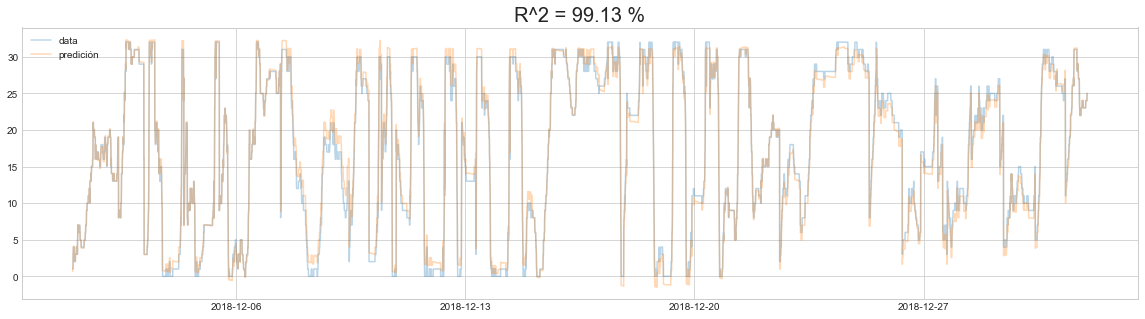

In [7]:
PCA_LinearRegression(XdC_1pt, ydC_1pt, 3, data[boolArr.values].index);

LLegamos a tener una correlación del 99.1%.

Y respecto a los pesos del PCA (pca.components_) se obtienen resultados parecidos al caso general sin identificador, como grandes pesos de nubes(``Clouds``), humedad(``Humidity``), temperatura(``°C``). Pero se distingue principalmente en que, como la altitud del parking no varía, su varianza es cero, ergo el ``PCA-0`` (ni ningún otro) se ve ya afectado por la altitud.